# Project 1
This project uses a dataset of credit card transations and whether or not they are fraudulent. The goal of the project is to train a model to correctly classify a credit card transation as fraud or not fraud. The project uses a decision tree and a Bernoulli Bayes Algorithm.

The dataset for this project can be found in the cited kaggle page (Eshum_malik).

This notebook's GitHub url can be found at: https://github.com/davege1107/ML-Fraud-Detection

Eshum_malik. (2025 &amp; September). SecurePay: Credit Card Fraud Detection Data, Version 1. Retrieved 9/26/2025 from https://www.kaggle.com/datasets/eshummalik/securepay-credit-card-fraud-detection-data/data.

## Part I: Set-up

In [45]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
import kagglehub
import os
import seaborn as sns
from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import Binarizer
from sklearn.pipeline import make_pipeline
%matplotlib inline

First, we will download the dataset.

In [31]:
directory = kagglehub.dataset_download("eshummalik/securepay-credit-card-fraud-detection-data")
filename = "creditcard.csv"
filepath = os.path.join(directory, filename)
print("Path to dataset files:", filepath)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\eshummalik\securepay-credit-card-fraud-detection-data\versions\1\creditcard.csv


In [32]:
df = pd.read_csv(filepath)
#print(df)

# save and organize feature names
feature_names = df.columns.tolist()
X = df.drop('Class', axis = 1).values
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 0)


## Part II: Exploratory Data Analysis

### IIA. Starter Dataset Inspection and Cleaning
No null or missing values are found, so data cleaning is unnecessary

In [64]:
# Shape and structure
print("Dataset shape:", df.shape)
print("Data Size: ", len(df))
# First few rows
print(df.head())

# Info: datatypes, non-null values
print(df.info())

# Summary statistics
print(df.describe())

# Check for null or missing values
print("Missing values per column:\n", df.isnull().sum())


Dataset shape: (284807, 31)
Data Size:  284807
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267

### IIB. Target Value Distribution
Check for the distribution of fraud vs. not-fraud

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Percentage distribution:
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


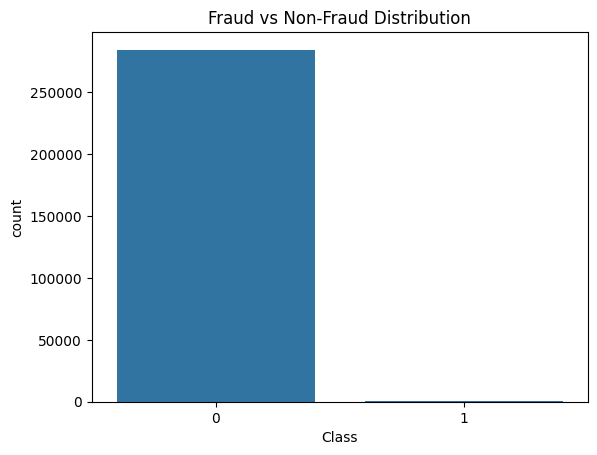

In [34]:
fraud_counts = df['Class'].value_counts()
fraud_percent = df['Class'].value_counts(normalize=True) * 100
print("Class distribution:\n", fraud_counts)
print("Percentage distribution:\n", fraud_percent)

sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


### IIC. Feature Distributions
Show the distributions of all the features

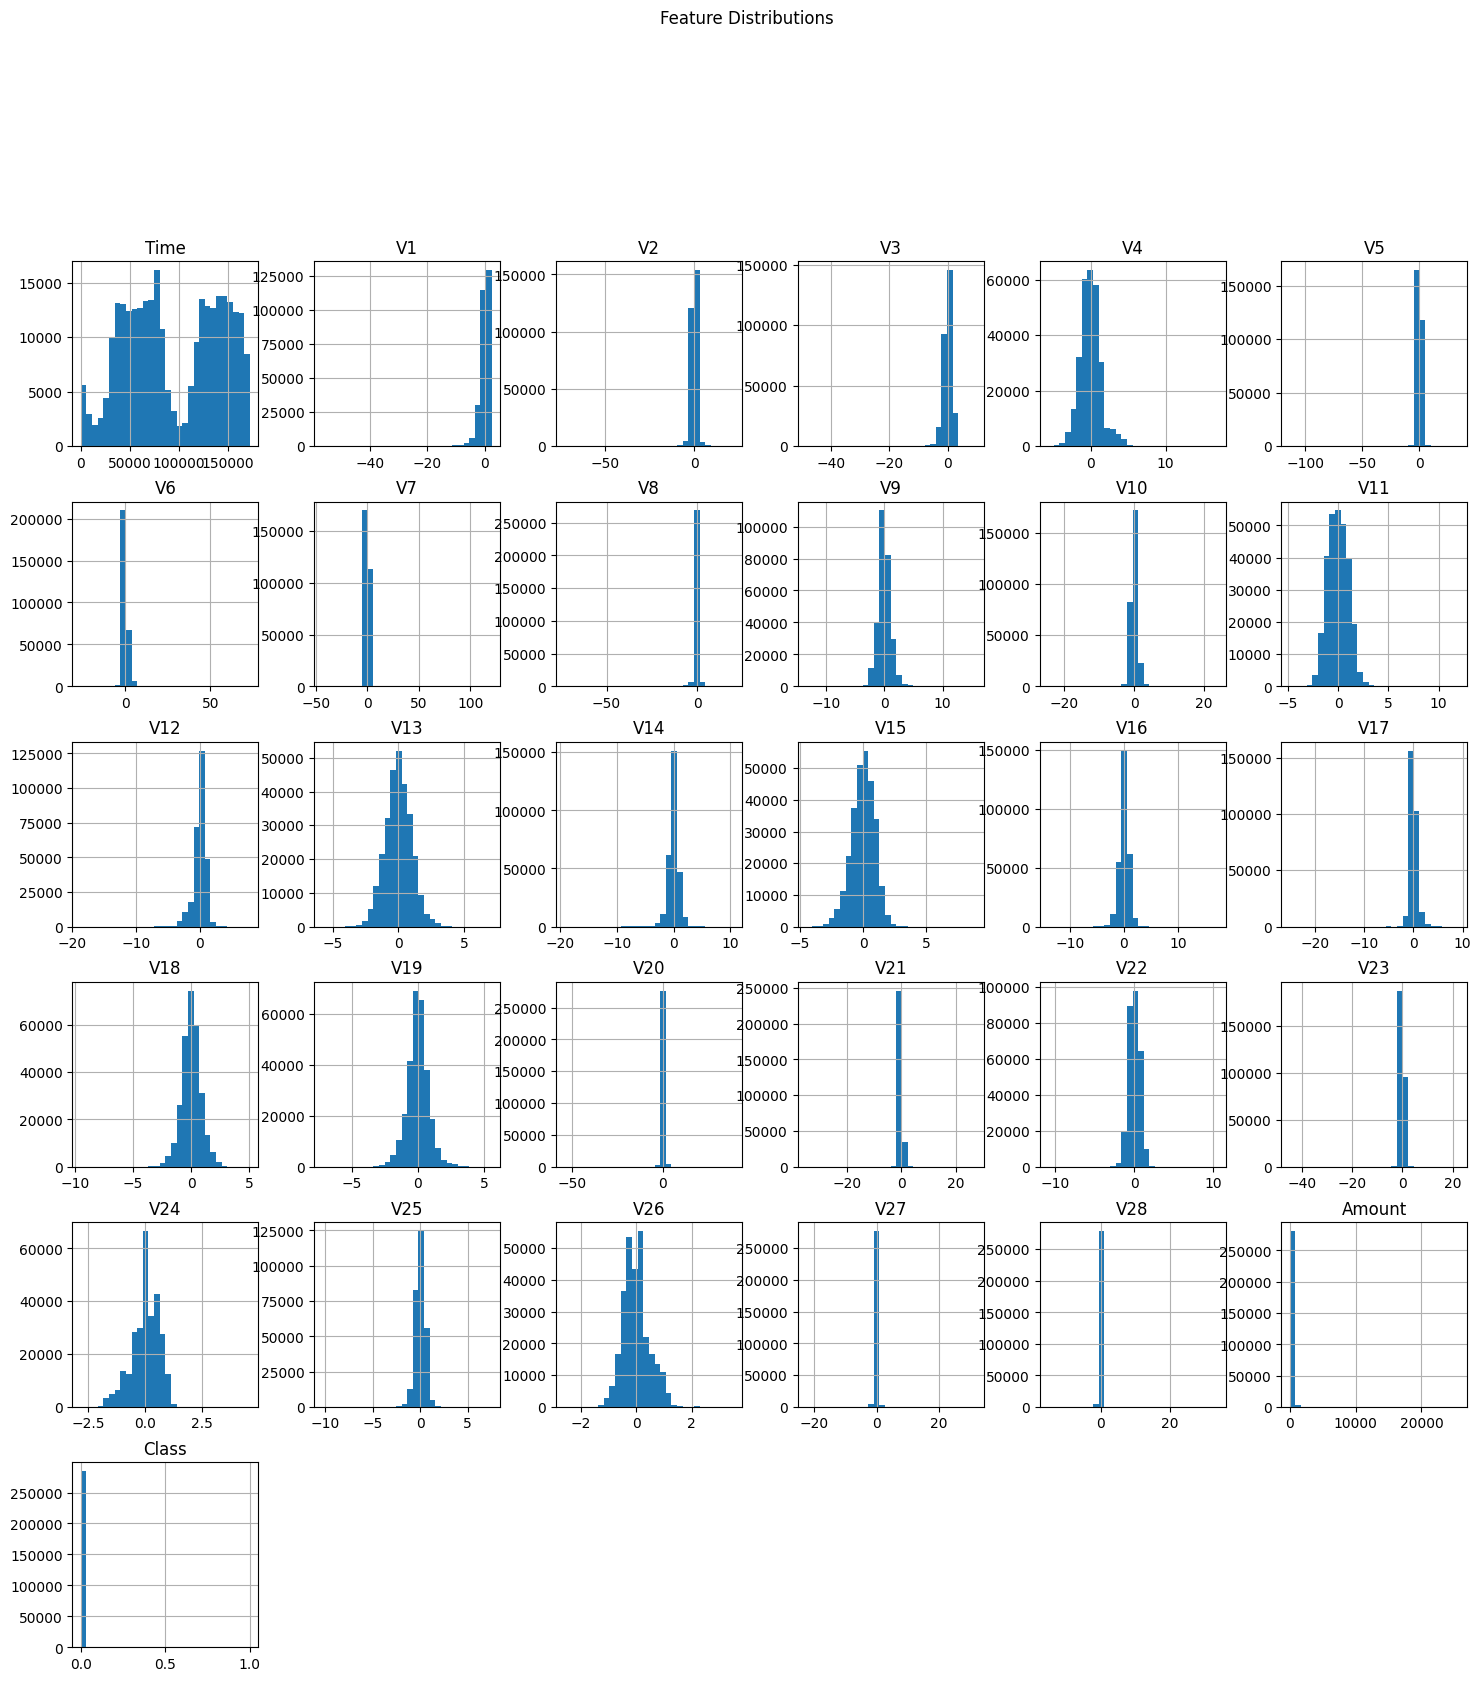

In [35]:
df.hist(figsize=(18, 18), bins=30)
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

### IID. Correlation Analysis
Shows correlation between the features in a heatmap

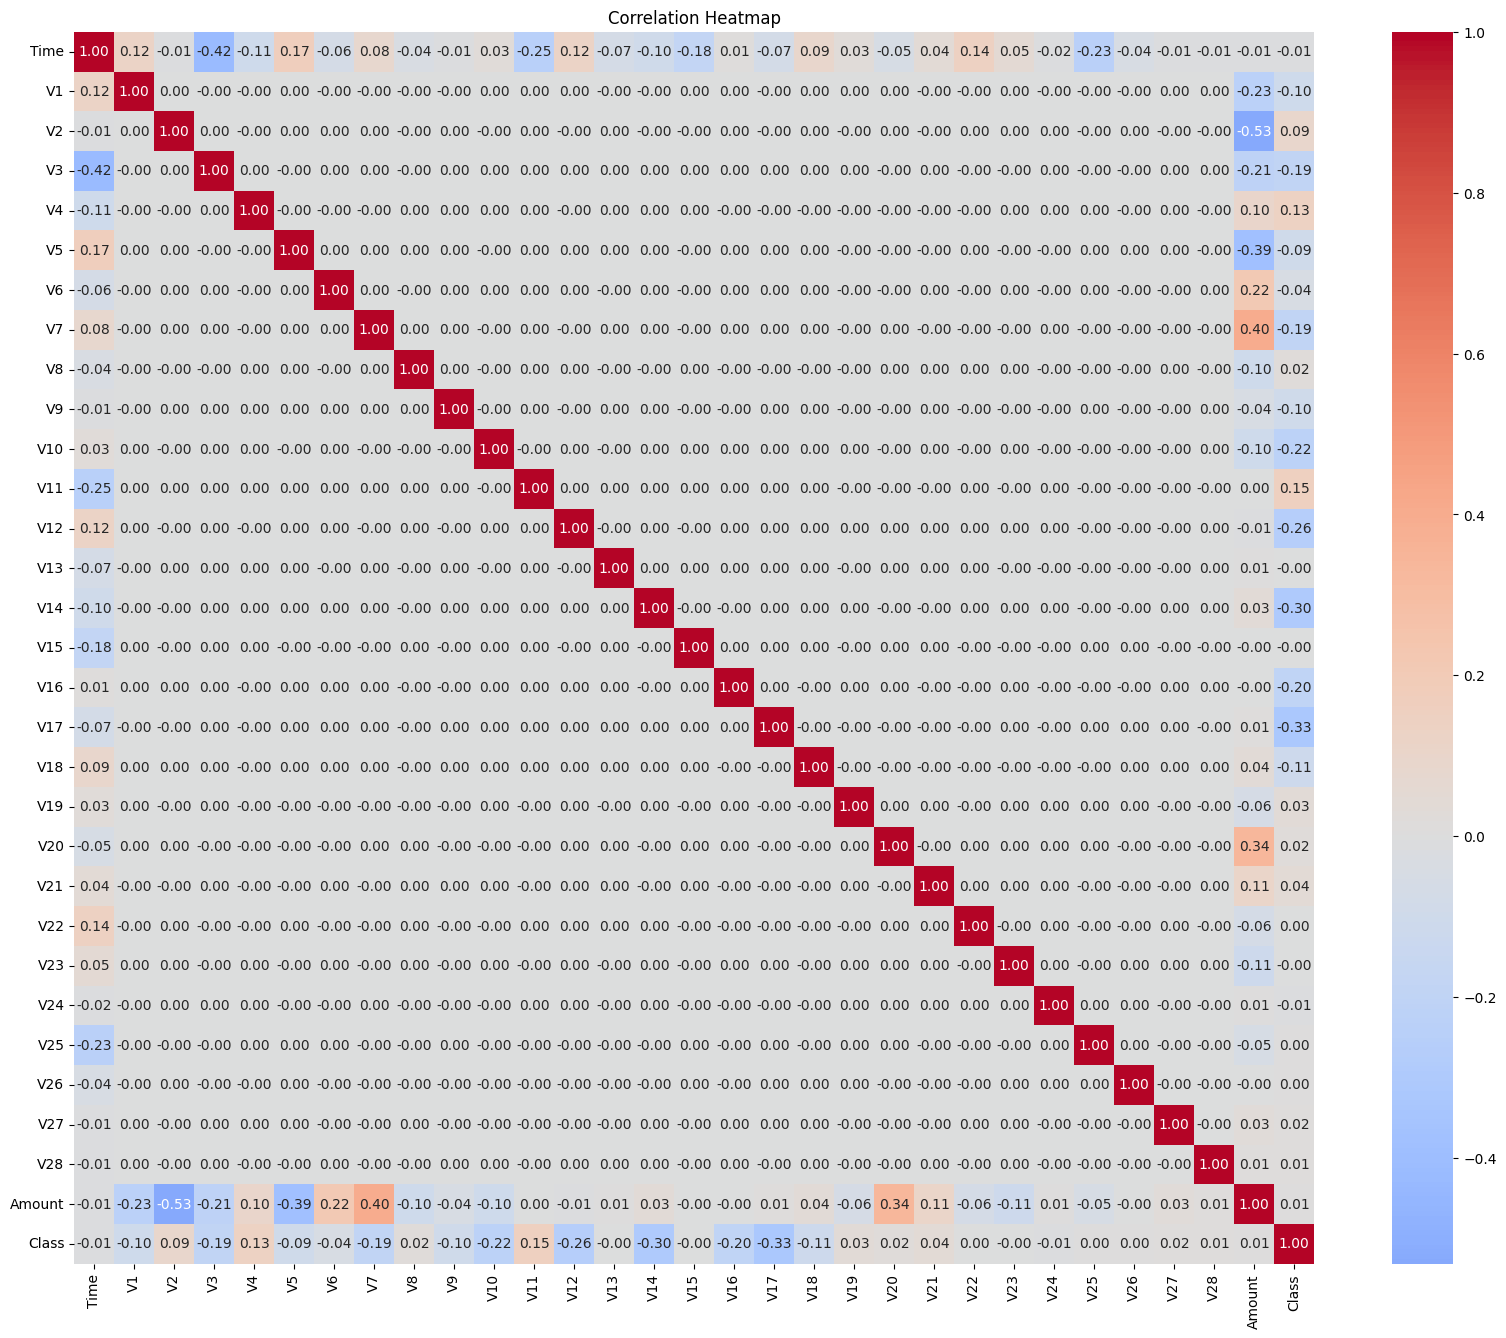

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


In [36]:
# Correlation matrix
corr_matrix = df.corr()

# Plot heatmap with values
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", center=0)
plt.title("Correlation Heatmap")
plt.show()

# Correlation with target
print(corr_matrix['Class'].sort_values(ascending=False))


### Discussion & Hypothesis
A decision tree classifier with pruning and a Naive Bayes Algorithm will be used for this project. The test size will be 25% of the total size. In addition, the resulting accuracy of the model is predicted to be 0.9 or above.

I am choosing a decision tree classifier because it is generally a good model, and I am choosing a Bernoulli Bayes Model because it is __[considered accurate for binary classification problems ](https://www.geeksforgeeks.org/machine-learning/bernoulli-naive-bayes/)__. 

## Part III: Model Building and Training

### Precision and Recall
Helper functions to calculate the precision and recall of the results.

In [38]:
def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    true_pos = np.sum((y_true == pos_label_value) & (y_pred == pos_label_value))
    
    false_pos = np.sum((y_pred == pos_label_value) & (y_true != pos_label_value))
    
    if true_pos + false_pos == 0:
        return 0.0
    
    precision = true_pos / (true_pos + false_pos)
    return precision
    
def calculate_recall(y_true, y_pred, pos_label_value=1.0):
    true_pos = np.sum((y_pred == pos_label_value) & (y_true == pos_label_value))
    
    false_pos = np.sum((y_pred != pos_label_value) & (y_true == pos_label_value))
    
    if true_pos + false_pos == 0:
        return 0.0
    
    recall = true_pos / (true_pos + false_pos)
    
    return recall
    

### Building the Initial Tree Model

In [53]:
dt_ = DecisionTreeClassifier(random_state = 0)
dt_.fit(X_train, y_train)

y_pred = dt_.predict(X_test)

prec = calculate_precision(y_test, y_pred, 1.0)
recall = calculate_recall(y_test, y_pred, 1.0)
print("Precision: ", prec)
print("Recall: ", recall)

Precision:  0.7338709677419355
Recall:  0.7583333333333333


### Pruning the Tree
The previous Decision Tree Classifier is good, but the precision and recall can be higher. We will use data pruning to bring it up. Pruning the tree can improve accuracy and decrease overfitting in the model.

In [54]:
clf = DecisionTreeClassifier(random_state = 0)
clf.fit(X_train, y_train)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train trees with different alphas
clfs = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    clfs.append(dt)

# Evaluate accuracy for each tree
accuracies1 = []
for dt in clfs:
    y_pred = dt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies1.append(acc)

# Find the best tree
best_idx = max(range(len(clfs)), key=lambda i: accuracies1[i])
best_alpha = ccp_alphas[best_idx]

# Find amounts false positives, false negatives, and true values
best_clf = clfs[best_idx]
y_pred_best = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
tn1, fp1, fn1, tp1 = cm.ravel()

# Get precision and recall
precision1 = calculate_precision(y_test, y_pred_best)
recall1 = calculate_recall(y_test, y_pred_best)


### Naive Bayes' Model
Using Bernoulli's Bayes Algorithm because the target is binary

In [57]:
# Train BernoulliNB with different hyperparameters.
# alpha is a smoothing parameter that prevents zero probabilities. 1.0 is the standard, but I am trying different options as well.
clfs = []
params_list = []
for alpha in [0.1, 0.5, 1.0, 2.0]:
    for fit_prior in [True, False]:
        # Pipeline: binarize features -> BernoulliNB
        nb = make_pipeline(
            Binarizer(threshold=0.0),   # adjust threshold if needed
            BernoulliNB(alpha=alpha, fit_prior=fit_prior)
        )
        nb.fit(X_train, y_train)
        clfs.append(nb)
        params_list.append({"alpha": alpha, "fit_prior": fit_prior})

# Evaluate accuracy for each model
accuracies2 = []
for nb in clfs:
    y_pred = nb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies2.append(acc)

# Find the best BernoulliNB
best_idx_B = max(range(len(clfs)), key=lambda i: accuracies2[i])
best_params = params_list[best_idx_B]
best_acc = accuracies2[best_idx_B]

best_clf = clfs[best_idx_B]
y_pred_best = best_clf.predict(X_test)

# Confusion matrix counts
cm = confusion_matrix(y_test, y_pred_best)
tn2, fp2, fn2, tp2 = cm.ravel()

# Precision and recall (your helper functions)
precision2 = calculate_precision(y_test, y_pred_best)
recall2 = calculate_recall(y_test, y_pred_best)

## Part IV: Results

### Results for Decision Tree Classifier

Best alpha: 9.117090612817516e-06
Best accuracy: 0.99950844077413558697
Precision: 0.9292929292929293
Recall: 0.7666666666666667

True Negatives: 71075
False Positives: 7
False Negatives: 28
True Positives: 92


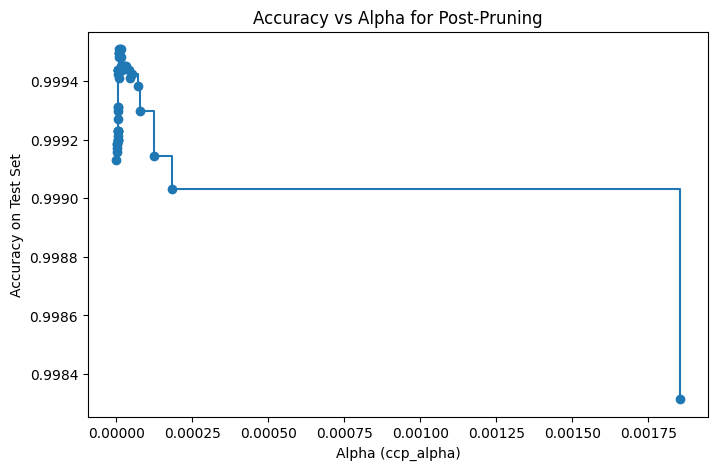

In [55]:
# Print Results
print(f"Best alpha: {best_alpha}")
print(f"Best accuracy: {accuracies1[best_idx]:.20f}")
print(f"Precision: {precision1}")
print(f"Recall: {recall1}\n")

# Print CM and T/F -/+
print(f"True Negatives: {tn1}")
print(f"False Positives: {fp1}")
print(f"False Negatives: {fn1}")
print(f"True Positives: {tp1}")


# Plot accuracy vs alpha
plt.figure(figsize=(8, 5))
plt.plot(ccp_alphas, accuracies1, marker='o', drawstyle="steps-post")
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Accuracy on Test Set")
plt.title("Accuracy vs Alpha for Post-Pruning")
plt.show()

### Results for Naive Bayes' Method

Best BernoulliNB params:  {'alpha': 0.1, 'fit_prior': True}
Best accuracy:  0.9991713715906857
Precision:  0.8210526315789474
Recall:  0.65
True Negatives: 71065
False Positives: 17
False Negatives: 42
True Positives: 78


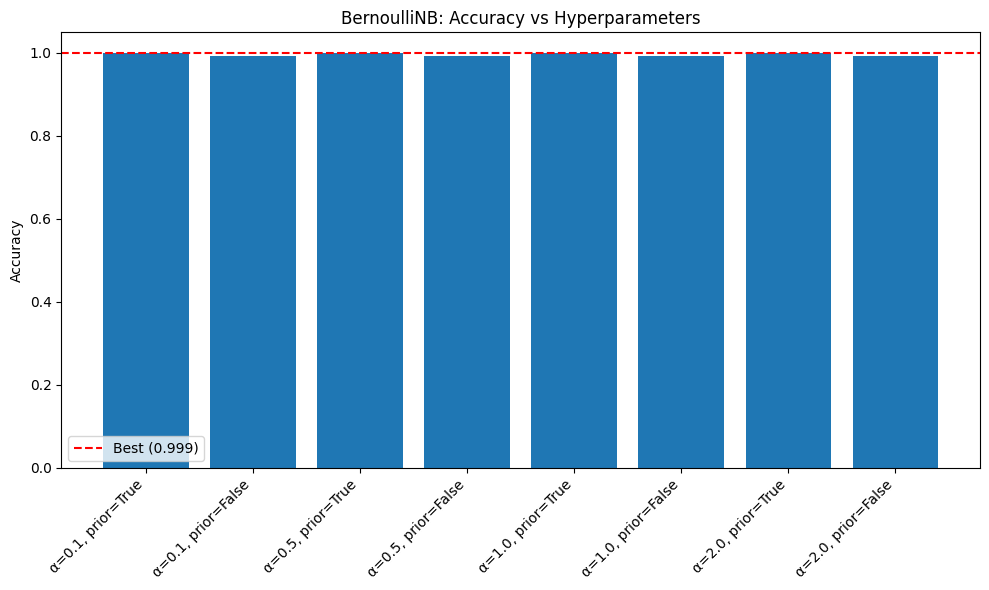

In [60]:
print("Best BernoulliNB params: ", best_params)
print("Best accuracy: ", best_acc)
print("Precision: ", precision2)
print("Recall: ", recall2)

# Print CM and T/F -/+
print(f"True Negatives: {tn2}")
print(f"False Positives: {fp2}")
print(f"False Negatives: {fn2}")
print(f"True Positives: {tp2}")

# Plot accuracy vs parameter
labels = [f"α={p['alpha']}, prior={p['fit_prior']}" for p in params_list]

plt.figure(figsize=(10,6))
plt.bar(labels, accuracies2)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("BernoulliNB: Accuracy vs Hyperparameters")
plt.axhline(best_acc, color="red", linestyle="--", label=f"Best ({best_acc:.3f})")
plt.legend()
plt.tight_layout()
plt.show()


## Part V: Discussion & Conclusion

The first model build for this project is a decision tree classifier with pruning, which greatly improved the precision from 0.857 to 0.929, making an 8% improvement. The initial recall score was 0.8, which decreased after pruning to 0.767, making a 4% decrease in recall score. The higher precision and lower recall show that the model is accurate in its positive predictions, but misses some true positives. This is confirmed by the 28 false negatives compared to 92 true positives. The low recall can partly be explained by the small amount of positive (fraud) entries in the dataset.



In conclusion, the 0.999 accuracy of 0.9 is greater than the predicted accuracy. Despite no single predictor being heavily correlated with the target (V11 being the highest), the model is accurate for the standards set in this project. In conclusion, the model's results confirm the hypothesis.

Further work on this topic should focus on making a random forest model instead of a decision tree classifier, which could further increase accuracy and decrease overfitting. A larger dataset with more positive fraud cases may also be helpful to train the data on more fraud examples, as it may be under-trained on positive examples when compared to negative ones.